USEFUL LINKS FOR DATA CLEANING:

https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/?utm_source=blog&utm_medium=stockmarketpredictionarticle

https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

https://www.relataly.com/stock-market-prediction-with-multivariate-time-series-in-python/1815/

In [142]:
import pandas as pd
import calendar as cd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

## DATA EXTRACTION AND CLEANING, FORMATTING, AND PLOTTING
### Data Extraction
Putting the dow jones csv data into a dataframe

In [143]:
dowjones_stocks = pd.read_csv("ES=F.csv")
dowjones_stocks_copy = dowjones_stocks.copy()
dowjones_stocks_copy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,1485.25,1489.75,1462.25,1467.5,1467.5,104794.0
1,2000-09-19,1467.00,1482.75,1466.75,1478.5,1478.5,103371.0
2,2000-09-20,1478.75,1480.50,1450.25,1469.5,1469.5,109667.0
3,2000-09-21,1470.25,1474.00,1455.50,1469.5,1469.5,98528.0
4,2000-09-22,1454.75,1471.00,1436.75,1468.5,1468.5,97416.0


### Data Cleaning

The Dow Jones stock price dataset contains a number of null records typically during holidays or weekends, which are days when the stock market is closed. To clean this dataset, we will simply remove all null records. Due to the missing dates, it should be noted that the stock price forecasting model will not predict stock prices for each subsequent days. Rather, we should assume that the forecasting model will predict stock prices for the next subsequent day in which the stock price would typically be observed and recorded.

In [144]:
dowjones_stocks_cleaned = dowjones_stocks_copy.loc[dowjones_stocks_copy["Open"].isnull() == False]
dowjones_stocks_cleaned = dowjones_stocks_cleaned.reset_index(drop=True)
dowjones_stocks_cleaned

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-09-18,1485.25,1489.75,1462.25,1467.50,1467.50,104794.0
1,2000-09-19,1467.00,1482.75,1466.75,1478.50,1478.50,103371.0
2,2000-09-20,1478.75,1480.50,1450.25,1469.50,1469.50,109667.0
3,2000-09-21,1470.25,1474.00,1455.50,1469.50,1469.50,98528.0
4,2000-09-22,1454.75,1471.00,1436.75,1468.50,1468.50,97416.0
...,...,...,...,...,...,...,...
5126,2020-11-16,3587.00,3637.00,3586.50,3623.00,3623.00,1303941.0
5127,2020-11-17,3625.50,3630.00,3584.25,3606.75,3606.75,1268206.0
5128,2020-11-18,3604.50,3623.25,3556.50,3565.00,3565.00,1325309.0
5129,2020-11-19,3562.00,3582.75,3542.25,3580.00,3580.00,1291117.0


Check if there are any null values left in the dataset. There are none left.

In [145]:
dowjones_stocks_cleaned.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [146]:
dowjones_stocks_cleaned.to_csv("(Clean)dowjones_stocks.csv")

### Data Plotting

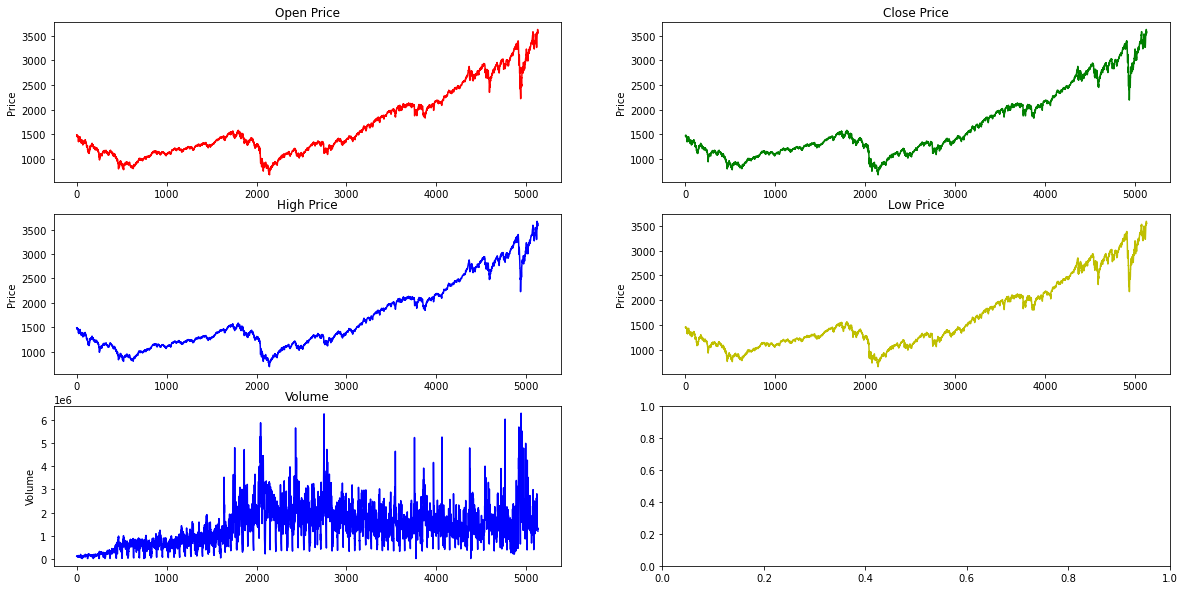

In [147]:
fig, dowjones_stocks_plots = plt.subplots(3,2,figsize=(20,10))

dowjones_stocks_plots[0,0].set_title("Open Price")
dowjones_stocks_plots[0,0].set_ylabel("Price")
dowjones_stocks_plots[0,0].plot(dowjones_stocks_cleaned.iloc[:,1], "r-")

dowjones_stocks_plots[0,1].set_title("Close Price")
dowjones_stocks_plots[0,1].set_ylabel("Price")
dowjones_stocks_plots[0,1].plot(dowjones_stocks_cleaned.iloc[:,4], "g-")

dowjones_stocks_plots[1,0].set_title("High Price")
dowjones_stocks_plots[1,0].set_ylabel("Price")
dowjones_stocks_plots[1,0].plot(dowjones_stocks_cleaned.iloc[:,2], "b-")

dowjones_stocks_plots[1,1].set_title("Low Price")
dowjones_stocks_plots[1,1].set_ylabel("Price")
dowjones_stocks_plots[1,1].plot(dowjones_stocks_cleaned.iloc[:,3], "y-")

dowjones_stocks_plots[2,0].set_title("Volume")
dowjones_stocks_plots[2,0].set_ylabel("Volume")
dowjones_stocks_plots[2,0].plot(dowjones_stocks_cleaned.iloc[:,6], "b-")

### Data Formatting

Reformat dataset so that the last column is the target column.

In [170]:
dowjones_stocks_reformatted = pd.concat([dowjones_stocks_cleaned.iloc[:,1:4], dowjones_stocks_cleaned.iloc[:,6]], 1)
dowjones_stocks_reformatted = pd.concat([dowjones_stocks_reformatted, dowjones_stocks_cleaned.iloc[:,4]], 1)
dowjones_stocks_reformatted.to_csv("dowjones_stocks_reformatted.csv")
dowjones_stocks_reformatted.head()

,Open,High,Low,Volume,Close
0,1485.25,1489.75,1462.25,104794.0,1467.5
1,1467.00,1482.75,1466.75,103371.0,1478.5
2,1478.75,1480.50,1450.25,109667.0,1469.5
3,1470.25,1474.00,1455.50,98528.0,1469.5
4,1454.75,1471.00,1436.75,97416.0,1468.5


In [149]:
# input steps are the number of time series steps that will be used to predict a set of future time steps
input_steps = 10
# outputs steps are the number of time series steps that will be predicted using the input time steps
output_steps = 9
# converting to array
dowjones_stocks_array = np.array(dowjones_stocks_reformatted)

The dataset is reformatted to have an input list, which contains a series of time steps to predict a series of time steps

In [150]:
dowjones_stocks_inputs = []
dowjones_stocks_outputs = []

for i in range(len(dowjones_stocks_array)):
    input_index_end = i + input_steps
    output_index_end= input_index_end + output_steps 
    
    if output_index_end > len(dowjones_stocks_array):
        break
    
    dowjones_stocks_inputs.append(dowjones_stocks_array[i:input_index_end, :])
    dowjones_stocks_outputs.append(dowjones_stocks_array[input_index_end:output_index_end, :])
    
dowjones_stocks_inputs = np.array(dowjones_stocks_inputs)
dowjones_stocks_outputs = np.array(dowjones_stocks_outputs)

In [151]:
dowjones_stocks_inputs[0:2]

array([[[  1485.25,   1489.75,   1462.25, 104794.  ,   1467.5 ],
        [  1467.  ,   1482.75,   1466.75, 103371.  ,   1478.5 ],
        [  1478.75,   1480.5 ,   1450.25, 109667.  ,   1469.5 ],
        [  1470.25,   1474.  ,   1455.5 ,  98528.  ,   1469.5 ],
        [  1454.75,   1471.  ,   1436.75,  97416.  ,   1468.5 ],
        [  1469.5 ,   1477.75,   1455.5 ,  85491.  ,   1461.  ],
        [  1461.  ,   1467.  ,   1442.5 ,  99803.  ,   1443.  ],
        [  1444.  ,   1456.  ,   1438.25, 101996.  ,   1446.75],
        [  1447.75,   1481.  ,   1445.  ,  84280.  ,   1476.  ],
        [  1473.  ,   1473.25,   1454.  ,  78277.  ,   1454.  ]],

       [[  1467.  ,   1482.75,   1466.75, 103371.  ,   1478.5 ],
        [  1478.75,   1480.5 ,   1450.25, 109667.  ,   1469.5 ],
        [  1470.25,   1474.  ,   1455.5 ,  98528.  ,   1469.5 ],
        [  1454.75,   1471.  ,   1436.75,  97416.  ,   1468.5 ],
        [  1469.5 ,   1477.75,   1455.5 ,  85491.  ,   1461.  ],
        [  1461.  ,   1

In [152]:
dowjones_stocks_outputs[0:2]

array([[[  1453.75,   1464.25,   1447.5 ,  84100.  ,   1456.25],
        [  1457.25,   1474.  ,   1438.75,  89440.  ,   1441.5 ],
        [  1442.  ,   1457.25,   1432.5 , 101607.  ,   1450.25],
        [  1449.5 ,   1462.  ,   1447.25,  92232.  ,   1456.  ],
        [  1456.  ,   1460.5 ,   1411.5 ,  95257.  ,   1426.25],
        [  1425.25,   1426.75,   1408.  ,  67432.  ,   1416.5 ],
        [  1417.5 ,   1424.5 ,   1390.  , 106613.  ,   1391.  ],
        [  1393.5 ,   1398.  ,   1361.75, 132059.  ,   1378.5 ],
        [  1379.5 ,   1387.75,   1339.  , 110135.  ,   1344.  ]],

       [[  1457.25,   1474.  ,   1438.75,  89440.  ,   1441.5 ],
        [  1442.  ,   1457.25,   1432.5 , 101607.  ,   1450.25],
        [  1449.5 ,   1462.  ,   1447.25,  92232.  ,   1456.  ],
        [  1456.  ,   1460.5 ,   1411.5 ,  95257.  ,   1426.25],
        [  1425.25,   1426.75,   1408.  ,  67432.  ,   1416.5 ],
        [  1417.5 ,   1424.5 ,   1390.  , 106613.  ,   1391.  ],
        [  1393.5 ,   1

## Model

Creating the LSTM model

In [174]:
# Number of features
num_features = dowjones_stocks_inputs[0].shape[1]

# The model
stock_model = keras.Sequential()
stock_model.add(LSTM(300, activation='relu', input_shape=(input_steps, num_features)))
stock_model.add(RepeatVector(output_steps))
stock_model.add(LSTM(300, activation='relu', return_sequences=True))
stock_model.add(TimeDistributed(Dense(num_features)))

stock_model.compile(optimizer='adam', loss='mse')
stock_model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 300)               367200    
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 9, 300)            0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 9, 300)            721200    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 9, 5)              1505      
Total params: 1,089,905
Trainable params: 1,089,905
Non-trainable params: 0
_________________________________________________________________


In [175]:
stock_model_history = stock_model.fit(dowjones_stocks_inputs, dowjones_stocks_outputs, epochs=200)
stock_model.save("stock_model.h5")

Epoch 1/200
160/160 [==============================] - 6s 40ms/step - loss: 165250908160.0000
Epoch 2/200
160/160 [==============================] - 7s 42ms/step - loss: 106772619264.0000
Epoch 3/200
160/160 [==============================] - 6s 40ms/step - loss: 95302983680.0000
Epoch 4/200
160/160 [==============================] - 6s 40ms/step - loss: 95875653632.0000
Epoch 5/200
160/160 [==============================] - 6s 39ms/step - loss: 88997920768.0000
Epoch 6/200
160/160 [==============================] - 6s 40ms/step - loss: 83734478848.0000
Epoch 7/200
160/160 [==============================] - 6s 40ms/step - loss: 79545516032.0000
Epoch 8/200
160/160 [==============================] - 6s 40ms/step - loss: 78595391488.0000
Epoch 9/200
160/160 [==============================] - 6s 39ms/step - loss: 75088764928.0000
Epoch 10/200
160/160 [==============================] - 6s 39ms/step - loss: 76349546496.0000
Epoch 11/200
160/160 [==============================] - 6s 40ms/ste

160/160 [==============================] - 6s 39ms/step - loss: 64145666048.0000
Epoch 89/200
160/160 [==============================] - 6s 40ms/step - loss: 64204447744.0000
Epoch 90/200
160/160 [==============================] - 6s 40ms/step - loss: 64343896064.0000
Epoch 91/200
160/160 [==============================] - 6s 40ms/step - loss: 64546041856.0000
Epoch 92/200
160/160 [==============================] - 6s 41ms/step - loss: 64585277440.0000
Epoch 93/200
160/160 [==============================] - 6s 41ms/step - loss: 64253554688.0000
Epoch 94/200
160/160 [==============================] - 7s 44ms/step - loss: 63936352256.0000
Epoch 95/200
160/160 [==============================] - 7s 43ms/step - loss: 63841910784.0000
Epoch 96/200
160/160 [==============================] - 7s 41ms/step - loss: 63504789504.0000
Epoch 97/200
160/160 [==============================] - 7s 41ms/step - loss: 63386292224.0000
Epoch 98/200
160/160 [==============================] - 7s 42ms/step - lo

160/160 [==============================] - 7s 43ms/step - loss: 61874155520.0000
Epoch 175/200
160/160 [==============================] - 6s 41ms/step - loss: 62019772416.0000
Epoch 176/200
160/160 [==============================] - 7s 41ms/step - loss: 61716865024.0000
Epoch 177/200
160/160 [==============================] - 7s 44ms/step - loss: 61387067392.0000: 
Epoch 178/200
160/160 [==============================] - 6s 40ms/step - loss: 61275340800.0000
Epoch 179/200
160/160 [==============================] - 7s 41ms/step - loss: 70042746880.0000
Epoch 180/200
160/160 [==============================] - 6s 40ms/step - loss: 67510407168.0000
Epoch 181/200
160/160 [==============================] - 6s 40ms/step - loss: 65254313984.0000
Epoch 182/200
160/160 [==============================] - 6s 40ms/step - loss: 64439676928.0000
Epoch 183/200
160/160 [==============================] - 7s 42ms/step - loss: 63839133696.0000
Epoch 184/200
160/160 [==============================] - 7s 43

In [176]:
# define model
stock_input = [[[3394.25, 3410, 3368.25, 1566246,3383],
[3369,3370.25,3260.75,2627180,3263.5],
[3279,3333.75,3250.25,1965277,3302.25],
[3268,3296.25,3225,2494925,3264.75],
[3260,3323.5,3243.25,1849320,3300.5],
[3304,3382.75,3301.25,1664690,3361.5],
[3362.75,3480,3319,2813083,3435],
[3448,3522.5,3428.25,1671417,3504.75],
[3508.75,3519,3456.75,1640000,3500.75],
[3522.5,3668,3515.75,2605322,3544]]]


stock_predictions = stock_model.predict(stock_input)

stock_predictions

array([[[2.6294587e+03, 2.6402495e+03, 2.6132686e+03, 2.2603752e+06,
         2.6398303e+03],
        [1.8678374e+03, 1.8786400e+03, 1.8785403e+03, 2.1225745e+06,
         1.8930889e+03],
        [2.7372078e+03, 2.7449141e+03, 2.7228081e+03, 2.0212091e+06,
         2.7547791e+03],
        [2.6334045e+03, 2.6378423e+03, 2.6208889e+03, 1.9788546e+06,
         2.6501267e+03],
        [2.5976624e+03, 2.6035061e+03, 2.5842246e+03, 1.9530764e+06,
         2.6155876e+03],
        [2.5939636e+03, 2.6002568e+03, 2.5801758e+03, 1.9444192e+06,
         2.6122444e+03],
        [2.5929695e+03, 2.5994497e+03, 2.5790742e+03, 1.9421351e+06,
         2.6113801e+03],
        [2.5930164e+03, 2.5995398e+03, 2.5790959e+03, 1.9416481e+06,
         2.6114548e+03],
        [2.5930491e+03, 2.5995815e+03, 2.5791235e+03, 1.9415679e+06,
         2.6114929e+03]]], dtype=float32)

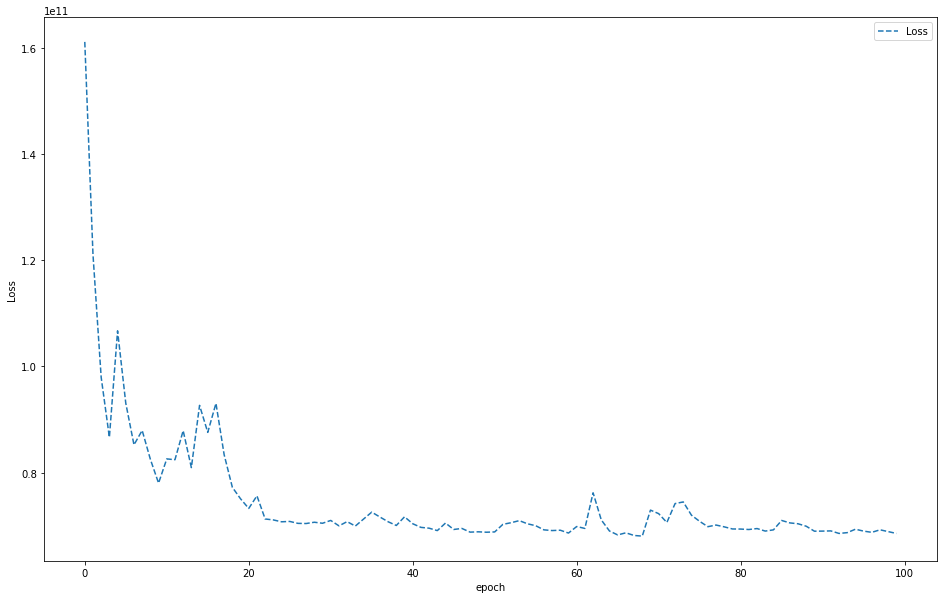

In [166]:
plt.figure(figsize=(16,10))
plt.plot(stock_model_history.epoch, stock_model_history.history['loss'],'--', label='Loss')
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [24]:
stock_model_history.history

{'loss': [6489.28173828125,
  8441.2109375,
  10284.328125,
  9539.90234375,
  10493.5361328125,
  9448.5537109375,
  7815.1025390625,
  13387.681640625,
  8483.908203125,
  7119.552734375,
  6512.21142578125,
  7675.96484375,
  8131.71142578125,
  8482.5576171875,
  12410.0166015625,
  7559.603515625,
  8980.5458984375,
  8586.9912109375,
  9120.8173828125,
  7771.1494140625,
  14018.951171875,
  26552.2578125,
  8194.4287109375,
  8446.388671875,
  7400.58984375,
  9910.3095703125,
  9703.376953125,
  7867.49853515625,
  6937.3173828125,
  6354.716796875,
  8787.2060546875,
  10597.732421875,
  7068.0390625,
  7073.90966796875,
  7373.873046875,
  10892.224609375,
  6520.904296875,
  7069.11083984375,
  8201.8564453125,
  7205.17724609375,
  9875.2998046875,
  8251.0185546875,
  7510.91357421875,
  7267.29736328125,
  11150.3095703125,
  10619.345703125,
  8100.955078125,
  10319.958984375,
  8314.4287109375,
  6222.35888671875,
  6698.89404296875,
  9378.09765625,
  7281.1513671875,